## Objective
Measure performance of neuropixels model on individual spikes

1. Histogram of RMS of detected and missed spikes
2. Store absolute deviation of predicted and actual spike locations
   
Commented code may have been needed for older version and/or section "Deprecated" analyses

In [1]:
%load_ext autoreload
%autoreload

# from importlib import reload
# from src import plot
# reload(plot)
# from src.plot import plot_hist_percents

# Update PATH to allow imports
import sys
sys.path.append("/data/MEAprojects/DLSpikeSorter")

# Imports
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import numpy as np
from src.model import ModelSpikeSorter
from src.utils import random_seed
from src import data, meta

In [2]:
# Get plotting data

# Set rec and model paths
REC_PATHS = meta.SI_MOUSE[:]
MODEL_PATHS = meta.SI_MODELS[:]
FACTOR_UV = meta.GAIN_TO_UV
THRESH_AMP = 36

NUM_SAMPLES = 1  # Number of sample to calculate probability of correctly predicting waveform

LOC_BUFFER = round(30*0.4)  # If |predicted_location - actual_location| <= LOC_BUFFER, the waveform will be regarded as correctly detected

RECORDING_COLORS = [  # Color for each recording in scatter plot
    "cyan",
    "green",
    'purple',
    'orange',
    'blue',
    'red'
]

NOISE_SAMPLE_SIZE = 1500  # Size of samples to extract to calculate noies

DTYPE = torch.float16

FILTER = data.BandpassFilter((300, 3000))
##
# Get total amps and probs across all recordings
# For scatter plot
# recording_name_to_color = {}
# amps_rms = []
# amps = []
# probs = []
# colors = []
#
# For histogram
amps_all = []  # Taken directly from sample
rmses_all = []  # RMS of sample
was_detected = []  # Whether spike was detected
loc_diffs_detected = []  # For detected spikes, deviation between predicted and actual location
#
for rec_path, model_path in zip(REC_PATHS, MODEL_PATHS):  # Iterate through each individual recording/model
    random_seed(231)
    # Get recording
    rec = rec_path.name
    # rec_color = RECORDING_COLORS.pop()
    # recording_name_to_color[rec] = rec_color

    # Get model
    model = ModelSpikeSorter.load(model_path).eval().to(DTYPE)

    # Get data
    dataset = data.MultiRecordingDataset.load_single(
        path_folder=rec_path,
        samples_per_waveform=1, front_buffer=model.buffer_front_sample, end_buffer=NOISE_SAMPLE_SIZE-model.sample_size+model.buffer_end_sample,
        num_wfs_probs=[0, 1], isi_wf_min=6, isi_wf_max=None,
        sample_size=NOISE_SAMPLE_SIZE,
        thresh_amp=THRESH_AMP, thresh_std=0.6, mmap_mode="r",
        device="cuda", dtype=DTYPE, gain_to_uv=FACTOR_UV,
    )
    # alpha_to_waveform_dict = dataset.get_alpha_to_waveform_dict()
    print(f"{rec}: {len(dataset)} waveforms")

    # Get prob and amp
    # colors += [rec_color] * len(dataset)
    for i in range(len(dataset)):
        amp = dataset.wf_datasets[0].waveforms[i].amp
        num_detected = 0
        for _ in range(NUM_SAMPLES):
            trace, num_wfs, wf_trace_locs, wf_alphas = dataset[i]

            trace_np = trace.cpu().numpy()
            rms = np.sqrt(np.mean(np.square(FILTER(trace_np))))

            with torch.no_grad():
                output = model(trace[None, :model.sample_size])
            pred = model.outputs_to_preds(output)[0]
            loc_diff = np.abs(pred - wf_trace_locs.item())
            if len(pred) > 0 and np.any(loc_diff <= LOC_BUFFER):
                num_detected += 1
                was_detected.append(True)
                loc_diffs_detected.append(min(loc_diff))
            else:
                was_detected.append(False)

            rmses_all.append(rms)
            amps_all.append(amp)
            # amps_raw.append(np.abs(trace[0, wf_trace_locs.item()].item() * FACTOR_UV))

        # amps.append(amp)

        # amp_rms_avg = np.mean(np.array([amps_raw[-NUM_SAMPLES:]]) / np.array(rmses[-NUM_SAMPLES:]) / 5)
        # amp_rms_avg = np.mean(amp / np.array(rmses[-NUM_SAMPLES:]) / 5)  # /5 so 5RMS
        # amps_rms.append(amp_rms_avg)

        # probs.append(100 * num_detected / NUM_SAMPLES)

Using random seed 231


probe_773592315: 750 waveforms
Using random seed 231
probe_773592318: 1040 waveforms
Using random seed 231
probe_773592320: 1655 waveforms
Using random seed 231
probe_773592324: 738 waveforms
Using random seed 231
probe_773592328: 1493 waveforms
Using random seed 231
probe_773592330: 576 waveforms


In [3]:
# Get amps histogram data
amps_detected = []
amps_failed = []
for amp, rms, detected in zip(amps_all, rmses_all, was_detected):
    amp = np.abs(amp)
    amp_norm = amp / rms
    if detected:
        amps_detected.append(amp_norm)
    else:
        amps_failed.append(amp_norm)
print(f"Min detected RMS: {min(amps_detected)}")

Min detected RMS: 0.1075384987372612


In [6]:
# Check X percentile
PERCENTILE = 5
print(f"{PERCENTILE} percentile: {np.percentile(amps_detected, PERCENTILE):.2f}")

5 percentile: 3.67


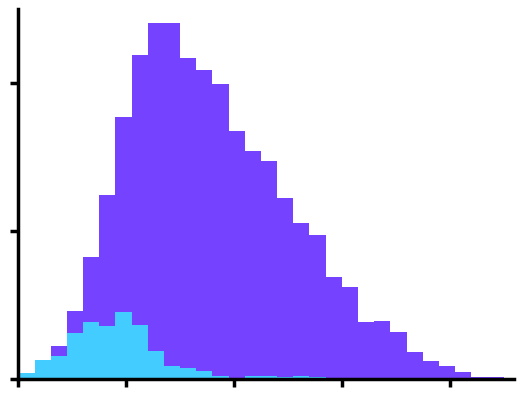

In [7]:
# Plot histogram of detected spikes (blue) and missed spikes (red)
BINS = np.arange(0, 23, 0.75)
plt.hist(amps_detected, alpha=1, color="#7542ff", bins=BINS)
plt.hist(amps_failed, alpha=1, color="#42ccff", bins=BINS)

# region Format for Nature manuscript
# Any of these can be None to not use these defined values
XTICKS = [0, 5, 10, 15, 20]
XLIM = [0, 23]

YTICKS = [0, 200, 400]
YLIM = [0, 500]
        
from pathlib import Path
SVG_PATH = Path("/data/MEAprojects/RT-Sort/figures/spike_detection_model_for_artificially_generated_samples/hist_num_detections_vs_spike_5rms/neuropixels.svg")

TICKS_PATH = SVG_PATH.parent / f"{SVG_PATH.name.split('.')[0]}_ticks.txt"  # Where to save ticks

SVG_PATH.parent.mkdir(exist_ok=True, parents=True)

ax = plt.gca()
# Hide top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Increase thickness of the bottom and left spines
ax.spines["bottom"].set_linewidth(2.5)
ax.spines["left"].set_linewidth(2.5)

# Increase thickness of tick marks
ax.tick_params(axis='both', direction='out', length=6, width=2.5, colors='black')

# Hide labels
ax.set_title("")
ax.set_xlabel("")
ax.set_ylabel("")

# Update ticks
if XTICKS is not None:
    ax.set_xticks(XTICKS, [''] * len(XTICKS))
    if XLIM is None:
        ax.set_xlim(XTICKS[0], XTICKS[-1])
    else:
        ax.set_xlim(*XLIM)
if YTICKS is not None:
    ax.set_yticks(YTICKS, [''] * len(YTICKS))
    if YLIM is None:
        ax.set_ylim(YTICKS[0], YTICKS[-1])
    else:
        ax.set_ylim(*YLIM)

# # Save figure
# plt.savefig(SVG_PATH, format="svg")
# plt.close()
# # Save ticks
# with open(TICKS_PATH, "w") as file:
#     file.write(f"x-ticks: {XTICKS}\ny-ticks: {YTICKS}")

np.save(SVG_PATH.parent / "neuropixels_amps_detected.npy", amps_detected)
np.save(SVG_PATH.parent / "neuropixels_amps_missed.npy", amps_failed)

plt.show()

# endregion

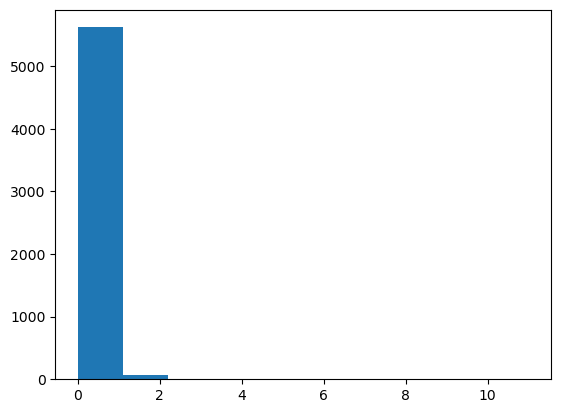

In [12]:
# Plot loc_diffs_detected as sanity check (all should be below LOC_BUFFER)
plt.hist(loc_diffs_detected)
plt.show()

In [13]:
# Save loc_diffs_detected
SAVE_PATH = Path("/data/MEAprojects/RT-Sort/figures/spike_detection_model_for_artificially_generated_samples/abs_deviation_between_predicted_and_actual/neuropixels.npy")
##
SAVE_PATH.parent.mkdir(exist_ok=True, parents=True)
np.save(SAVE_PATH, loc_diffs_detected)